#1. IMPORTING LIB TO DO ANALYSIS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats import weightstats as ssw

# 1. DATA LOADING

In [ ]:
# Loading dataset
df = pd.read_csv('/content/drive/MyDrive/stats/hotel_bookings.csv')

#1. OVERVIEW OF DATASET

In [ ]:
df.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01


In [ ]:
print(df.shape)
print(df.info())
print("Null value count\n",df.isnull().sum())

(119390, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  mea

#2. DATA CLEANING & PREPROCESSING

In [ ]:
#Handling null values
df['children'].fillna(0, inplace=True)
df['country'].fillna(df['country'].mode()[0], inplace=True)
df['agent'].fillna(-1, inplace=True)
df['company'].fillna(-1, inplace=True)

#Dropping rows with remaining missing values
df.dropna(inplace=True)

#Changing data type for reservation_status_dat and arrival_date
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['arrival_date'] = pd.to_datetime(df['arrival_date_year'].astype(str) + '-' +
                                    df['arrival_date_month'] + '-' +
                                    df['arrival_date_day_of_month'].astype(str))

#Droping duplicate values
df.drop_duplicates(inplace=True)
df['agent'] = df['agent'].astype(int)
df['company'] = df['company'].astype(int)

<ipython-input-16-0b0602bd8b28>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['children'].fillna(0, inplace=True)
<ipython-input-16-0b0602bd8b28>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

#2.1 Outlier Detection and Handling

In [ ]:
#Outlier detection using IQR for ADR
Q1 = df['adr'].quantile(0.25)
Q3 = df['adr'].quantile(0.75)
IQR = Q3 - Q1

# Seting upper and lower bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Outlier bounds for ADR: {lower_bound:.2f} to {upper_bound:.2f}")

#Removing outliers
print(f"Total rows before reoving ADR outliers: {df.shape[0]}")
df = df[(df['adr'] >= lower_bound) & (df['adr'] <= upper_bound)]
print(f"Remaining rows after removing ADR outliers: {df.shape[0]}")

Outlier bounds for ADR: -17.25 to 218.35
Total rows before reoving ADR outliers: 84889
Remaining rows after removing ADR outliers: 84262


#3. EXPLORATORY DATA ANALYSIS (EDA)

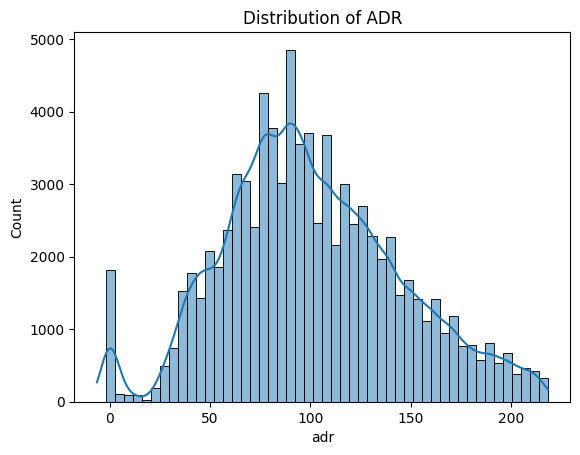

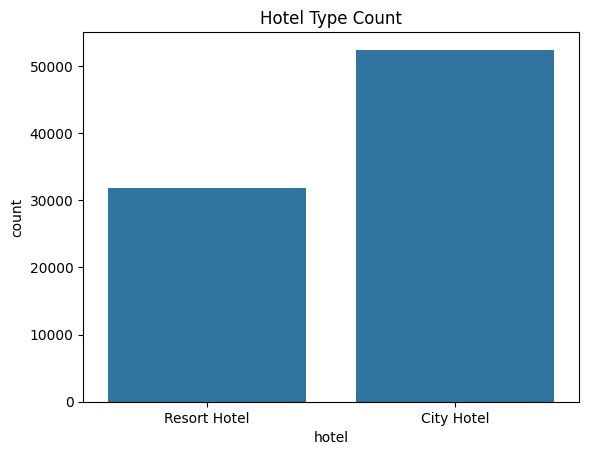

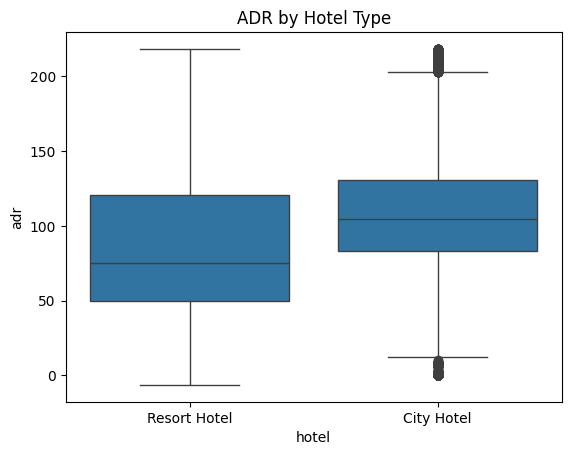

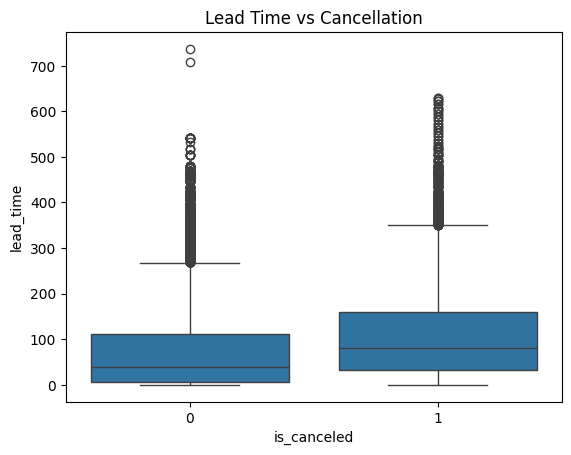

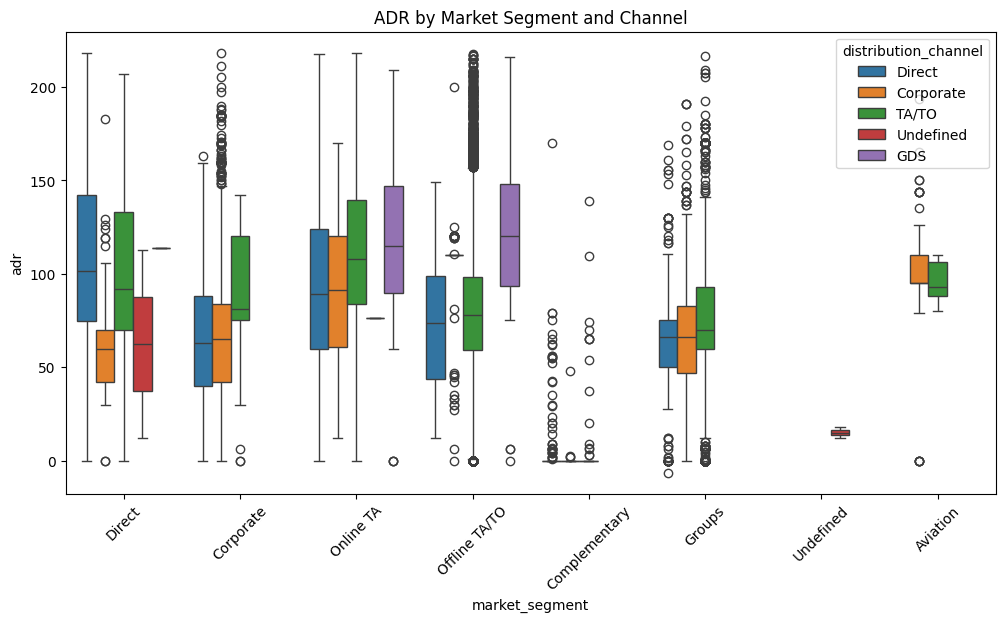

In [ ]:
#Visualizatin of ADR distribution
sns.histplot(df['adr'], bins=50, kde=True)
plt.title('Distribution of ADR')
plt.show()

#Visualization of Hotel Type and Their count
sns.countplot(x='hotel', data=df)
plt.title('Hotel Type Count')
plt.show()

#Visualization of ADR by Hotel Type
sns.boxplot(x='hotel', y='adr', data=df)
plt.title('ADR by Hotel Type')
plt.show()

#Visualization of Lead Time vs Cancellation graph
sns.boxplot(x='is_canceled', y='lead_time', data=df)
plt.title('Lead Time vs Cancellation')
plt.show()

#Visualization of Market Segment and Chennel
plt.figure(figsize=(12,6))
sns.boxplot(x='market_segment', y='adr', hue='distribution_channel', data=df)
plt.xticks(rotation=45)
plt.title('ADR by Market Segment and Channel')
plt.show()

#3.1 Time-Series Analysis of Booking

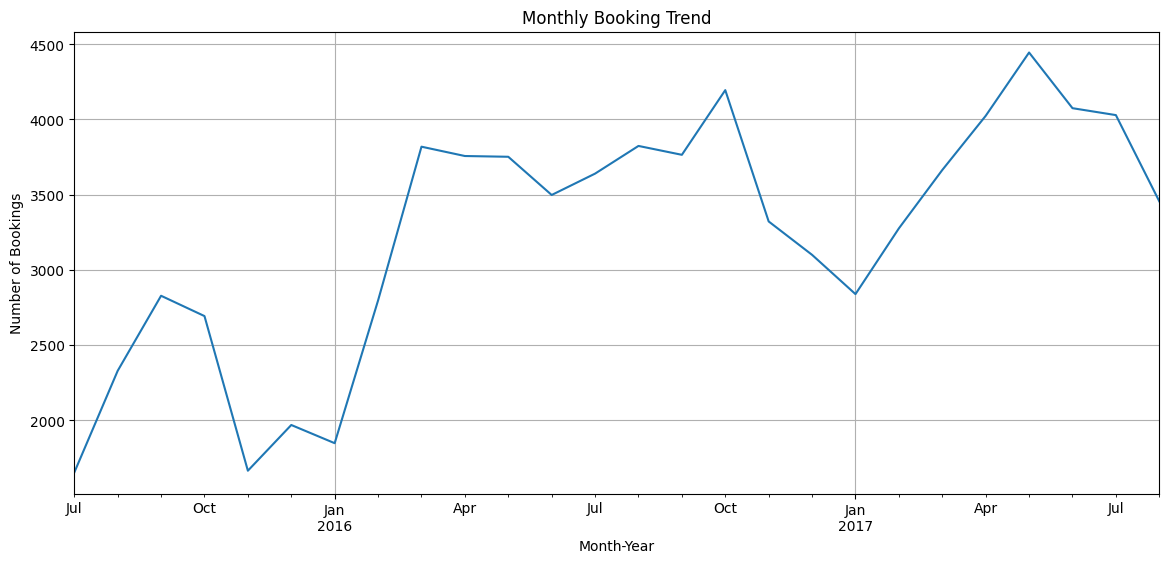

In [ ]:
#Time-series plot: Number of bookings per month and per year
df['arrival_date_month_year'] = df['arrival_date'].dt.to_period('M').dt.to_timestamp()

monthly_bookings = df.groupby('arrival_date_month_year').size()

plt.figure(figsize=(14,6))
monthly_bookings.plot()
plt.title("Monthly Booking Trend")
plt.xlabel("Month-Year")
plt.ylabel("Number of Bookings")
plt.grid(True)
plt.show()

#3.2 Booking Trend by Year and Month

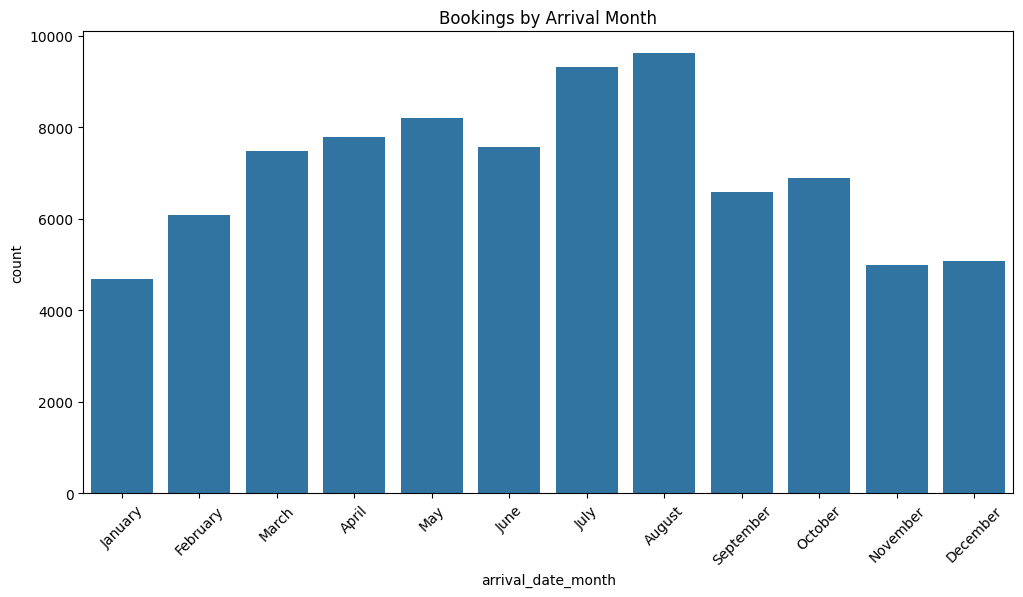

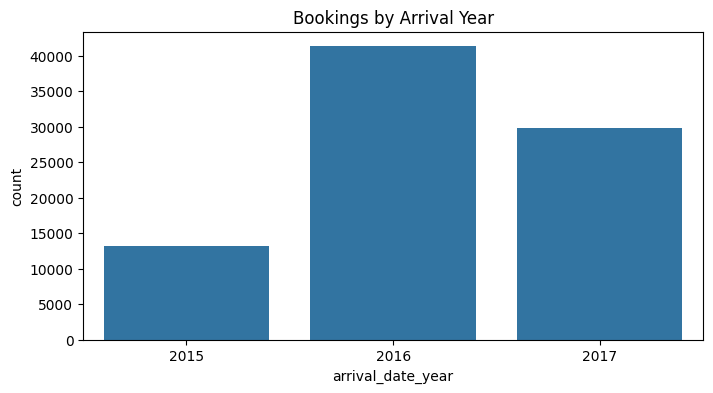

In [ ]:
#Number of bookings per arrival month
plt.figure(figsize=(12,6))
sns.countplot(x='arrival_date_month', data=df,
              order=['January', 'February', 'March', 'April', 'May', 'June',
                     'July', 'August', 'September', 'October', 'November', 'December'])
plt.title("Bookings by Arrival Month")
plt.xticks(rotation=45)
plt.show()

#Number of bookings per year
plt.figure(figsize=(8,4))
sns.countplot(x='arrival_date_year', data=df)
plt.title("Bookings by Arrival Year")
plt.show()


#3.3 Hotel Guest Demographics by Country

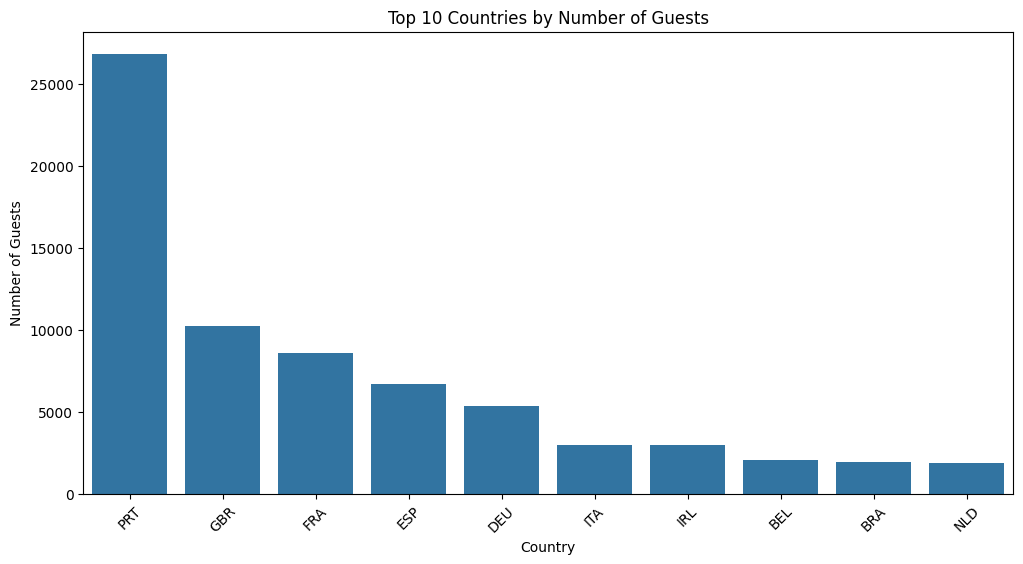

In [ ]:
#Top 10 countries by number of guests
top_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top 10 Countries by Number of Guests")
plt.ylabel("Number of Guests")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.show()

# 🔁 4. CORRELATION ANALYSIS

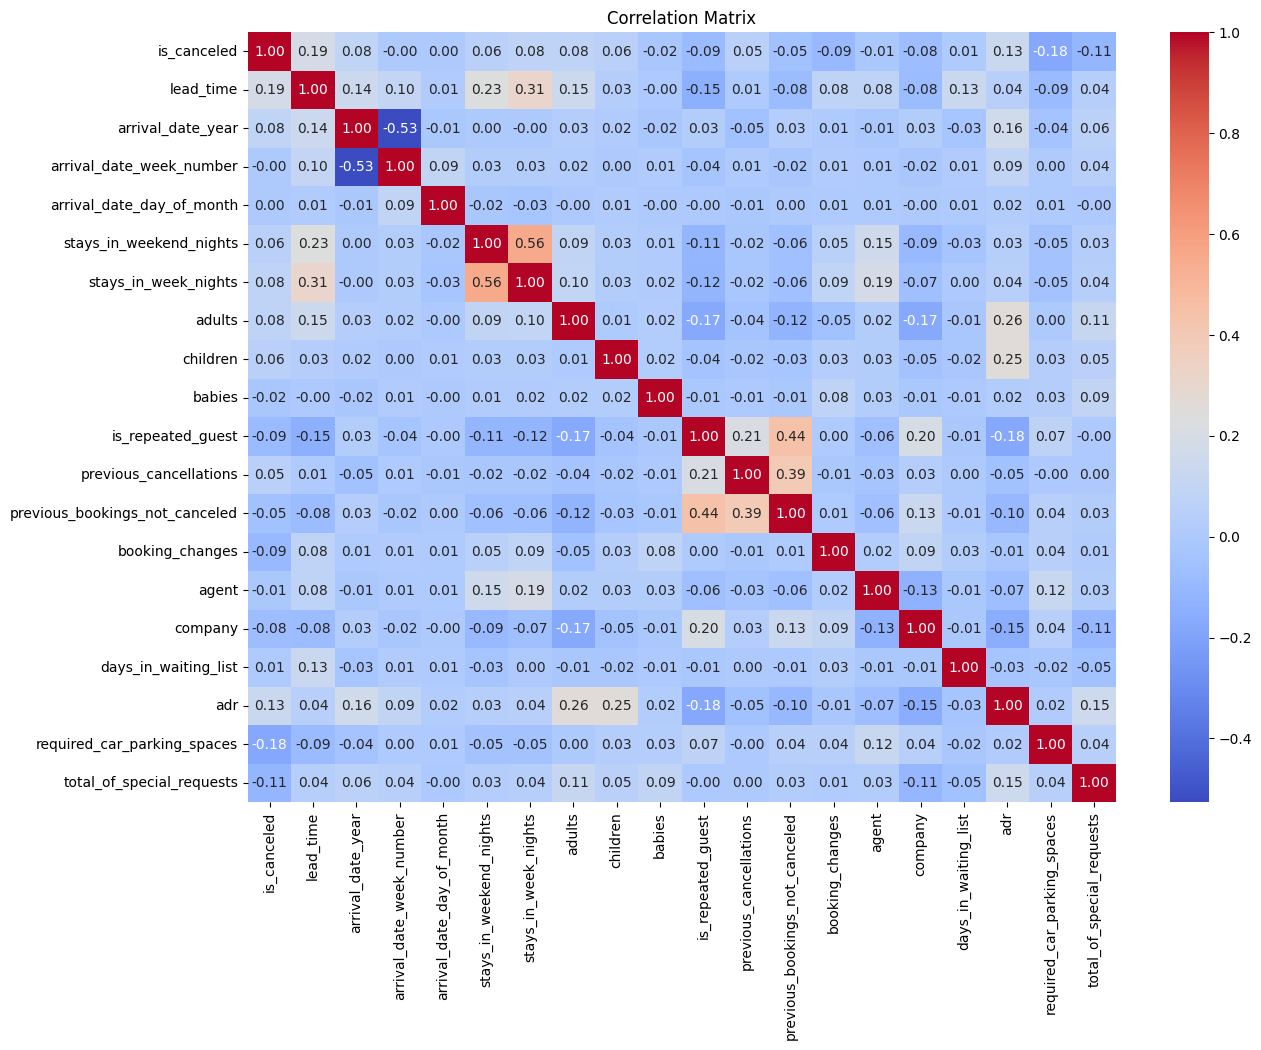

adr                               1.000000
adults                            0.256141
children                          0.251798
arrival_date_year                 0.163620
total_of_special_requests         0.152580
is_canceled                       0.134031
arrival_date_week_number          0.090104
lead_time                         0.043666
stays_in_week_nights              0.043449
stays_in_weekend_nights           0.034414
arrival_date_day_of_month         0.017888
babies                            0.016905
required_car_parking_spaces       0.015226
booking_changes                  -0.014993
days_in_waiting_list             -0.034579
previous_cancellations           -0.054517
agent                            -0.070673
previous_bookings_not_canceled   -0.097104
company                          -0.153587
is_repeated_guest                -0.179887
Name: adr, dtype: float64


In [ ]:
#Visualization of correlation between numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[num_cols].corr(method='pearson')
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True,fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
adr_corr = corr['adr'].sort_values(ascending=False)
print(adr_corr)

#5. HYPOTHESIS TESTING

#5.1 H0: No ADR difference between Online TA and Direct

In [ ]:
group1 = df[df['distribution_channel'] == 'TA/TO']['adr']
group2 = df[df['distribution_channel'] == 'Direct']['adr']

t_stat, p_val = ttest_ind(group1,group2,equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

if p_val < 0.05:
    print("Rejected null hypothesis H0: Significant ADR difference exists.")
else:
    print("Accepted null hypothesis H0: No significant ADR difference.")


T-statistic: 7.677545623880186, P-value: 1.7193322596831873e-14
Rejected null hypothesis H0: Significant ADR difference exists.


#5.2 H0: Room upgrades are independent of lead time

In [ ]:
#Putting upgrade as  0,1 feature
df['room_upgraded'] = (df['assigned_room_type'] != df['reserved_room_type']).astype(int)

# T-test on lead_time vs room upgrade
t_stat, p_val = ttest_ind(df[df['room_upgraded'] == 1]['lead_time'],
                          df[df['room_upgraded'] == 0]['lead_time'],
                          equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_val}")
if p_val < 0.05:
    print("Rejected null hypothesis H0: Significant difference exists.")
else:
    print("Accepted null hypothesis H0: No significant difference.")

T-statistic: -33.28920678308763, P-value: 3.8509843717577845e-236
Rejected null hypothesis H0: Significant difference exists.


#5.3 H0: Average stay duration does not differ between customer types

In [ ]:
from scipy.stats import f_oneway

#Creating stay_duration column
df['stay_duration'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# Extracting stay_duration for each customer_type group
group_transient = df[df['customer_type'] == 'Transient']['stay_duration'].dropna()
group_contract = df[df['customer_type'] == 'Contract']['stay_duration'].dropna()
group_transient_party = df[df['customer_type'] == 'Transient-Party']['stay_duration'].dropna()
group_group = df[df['customer_type'] == 'Group']['stay_duration'].dropna()

#One-way ANOVA test
f_stat, p_val = f_oneway(group_transient, group_contract, group_transient_party, group_group)
print(f"F-statistic: {f_stat}, P-value: {p_val}")
if p_val < 0.05:
    print("Rejected H0: At least one customer type has a significantly different average stay duration.")
else:
    print("Accepted H0: No significant difference in average stay duration among customer types.")


F-statistic: 887.6943059534884, P-value: 0.0
Rejected H0: At least one customer type has a significantly different average stay duration.


#5.4 H0: Guests with more special requests have higher ADR

In [ ]:
# Group by special requests
group1 = df[df['total_of_special_requests'] > 0]['adr']
group2 = df[df['total_of_special_requests'] == 0]['adr']

t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
print(f"H0 - Special Requests vs ADR: T-stat = {t_stat:.2f}, p = {p_val:.4f}")
if p_val < 0.05:
    print("Rejected H0.")
else:
    print("Accepted H0.")


H0 - Special Requests vs ADR: T-stat = 41.31, p = 0.0000
Rejected H0.


#5.5 Guests who cancel have longer lead time

In [ ]:
group1 = df[df['is_canceled'] == 1]['lead_time'].dropna()
group2 = df[df['is_canceled'] == 0]['lead_time'].dropna()

t_stat, p_val = ttest_ind(group1, group2, equal_var=False,alternative='less')
print(f"H0 - Lead Time vs Cancellation: T-stat = {t_stat:.2f}, p = {p_val:.4f}")
if p_val < 0.05:
    print("Rejected H0.")
else:
    print("Accepted H0.")


H5 - Lead Time vs Cancellation: T-stat = 51.85, p = 1.0000
Accepted H0.


#5.6 H0: Room reassignments are more frequent in City Hotel than Resort Hotel

In [ ]:
df['room_changed'] = (df['assigned_room_type'] != df['reserved_room_type']).astype(int)

city = df[df['hotel'] == 'City Hotel']['room_changed']
resort = df[df['hotel'] == 'Resort Hotel']['room_changed']

t_stat, p_val = ttest_ind(city, resort, equal_var=False,alternative='less')
print(f"H0 - Room Changes City vs Resort: T-stat = {t_stat:.2f}, p = {p_val:.4f}")
if p_val < 0.05:
    print("Rejected H0.")
else:
    print("Accepted H0.")

H0 - Room Changes City vs Resort: T-stat = -37.44, p = 0.0000
Rejected H0.


#6 BUSINESS INSIGHTS

Room upgrade rate: 15.34%


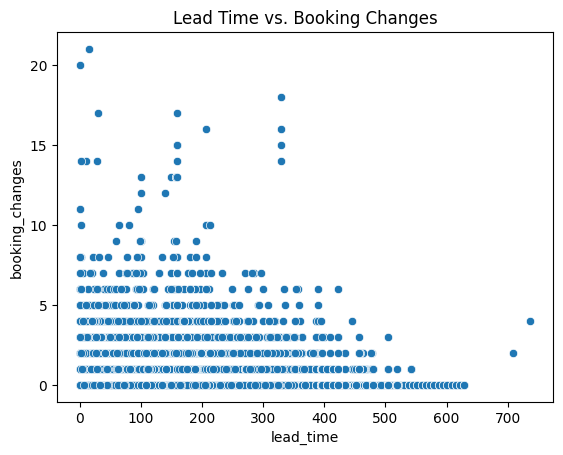

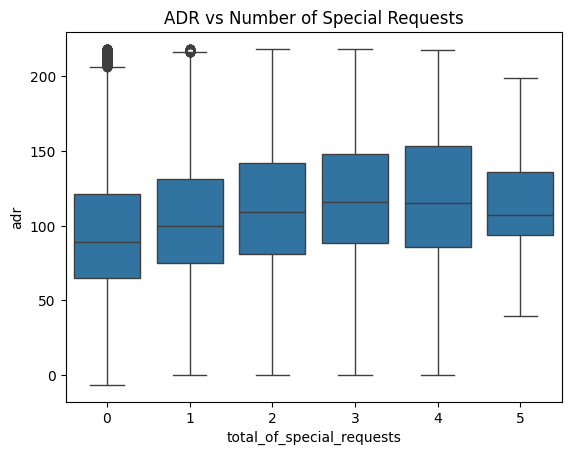

country
AND    1.0
BEN    1.0
IMN    1.0
HND    1.0
NIC    1.0
UMI    1.0
VGB    1.0
MYT    1.0
KHM    1.0
JEY    1.0
Name: is_canceled, dtype: float64


In [ ]:
# Room upgrade rate
upgrade_rate = df['room_upgraded'].mean()
print(f"Room upgrade rate: {upgrade_rate:.2%}")

# Booking changes vs. lead time
sns.scatterplot(x='lead_time', y='booking_changes', data=df)
plt.title('Lead Time vs. Booking Changes')
plt.show()

# Special requests vs. ADR
sns.boxplot(x='total_of_special_requests', y='adr', data=df)
plt.title('ADR vs Number of Special Requests')
plt.show()

# Cancellation rate by country
cancel_by_country = df.groupby('country')['is_canceled'].mean().sort_values(ascending=False).head(10)
print(cancel_by_country)
